In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from collections import OrderedDict
import numpy as np
%matplotlib inline
import cv2
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix  
from collections import Counter
import random

data_dir = "../input/kimoanh29/DATA_CHAMBER_2021/"
plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("You are using CUDA")

You are using CUDA


In [2]:
import os
from os import listdir, makedirs, getcwd, remove
from os.path import join, exists, expanduser

cache_dir = expanduser(join('~', '.torch'))

if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    
    makedirs(models_dir)
    
!cp ../input/pretrained-pytorch-models/* ~/.torch/models/
!ls ~/.torch/models

densenet161-17b70270.pth	  resnet50-19c8e357.pth
inception_v3_google-1a9a5a14.pth  squeezenet1_0-a815701f.pth
resnet18-5c106cde.pth		  squeezenet1_1-f364aa15.pth


In [3]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract = False, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg19_bn":
        """ VGG16_bn
        """
        model_ft = models.vgg19_bn().load_state_dict(torch.load("../input/vgg19bn/vgg19_bn.pth"))
        set_parameter_requires_grad(model_ft, feature_extract)
        num_features = vgg16.classifier[6].in_features
        features = list(vgg16.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, len(num_classes))]) # Add our layer with 4 outputs
        vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
        input_size = 224
    elif model_name == "vgg16_bn":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn().load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
        set_parameter_requires_grad(model_ft, feature_extract)
        num_features = vgg16.classifier[6].in_features
        features = list(vgg16.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, len(num_classes))]) # Add our layer with 4 outputs
        vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model('resnet50',3,feature_extract = False, use_pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

* Preprocessing Image

In [6]:
def opening(img):
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=1)
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=1)
    return img_dilation
def denoise(img):
    denoise_img = cv2.bilateralFilter(img, 15, 75, 75)
    return denoise_img

In [7]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [8]:
from PIL import Image
from matplotlib import cm
def preprocessing(img):
    return Image.fromarray(np.uint8(apply_brightness_contrast(opening(denoise(np.array(img))),0,16)))

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        preprocessing,
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        preprocessing,
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}




image_datasets = {
    'train': 
    ImageFolderWithPaths(data_dir + 'train', data_transforms['train']),
    'test': 
    ImageFolderWithPaths(data_dir + 'test', data_transforms['test'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=16,
                                shuffle=True,
                                num_workers=2),  # for Kaggle
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=16,
                                shuffle=False,
                                num_workers=2)  # for Kaggle
}
label = image_datasets['train'].classes

# See some statistics
print(dataloaders)
len(dataloaders['train'])

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fc4a012ae50>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7fc4a012af50>}


420

In [10]:
for x in ['train', 'test']:
    print("Loaded {} images in {}".format(dataset_sizes[x], x))
    
print("Classes: ")

label = image_datasets['train'].classes
print(image_datasets['train'].classes)

Loaded 6717 images in train
Loaded 1607 images in test
Classes: 
['2C', '3C', '4C']


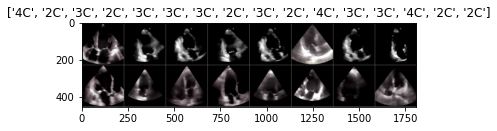

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# Get a batch of training data
inputs, classes,_ = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[label[x] for x in classes])

* Training model

In [12]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=10, is_inception=False, device = 'cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_values = []
    acc_values = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            train_batches = len(dataloaders[phase])
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i,(inputs, labels,_) in enumerate(dataloaders[phase]):
                print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    _, preds = torch.max(outputs, 1)
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            loss_values.append(epoch_loss)
            acc_values.append(epoch_acc)

            print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,acc_values,loss_values

* Visualizing the model predictions
* Generic function to display predictions for a few images

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return model.train(mode=was_training)

In [14]:
def test_model(model, criterion, optimizer):
    labels_input=list()
    labels_output=list()
    vid_id = list()
    for phase in ['test']:
        model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels, fname in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input= labels_input + labels.tolist()
            for f in fname:
                vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output= labels_output + preds.tolist()
    return labels_input,labels_output,vid_id

In [15]:
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_conv = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [16]:
model_ft,acc,loss = train_model(model_ft, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5, is_inception=False, device = 'cuda')

Epoch 0/4
----------


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training batch 420/420
train Loss: 0.2596 Acc: 0.9090
Training batch 101/101
test Loss: 0.8148 Acc: 0.7231

Epoch 1/4
----------
Training batch 420/420
train Loss: 0.0164 Acc: 0.9952
Training batch 101/101
test Loss: 0.2882 Acc: 0.8979

Epoch 2/4
----------
Training batch 420/420
train Loss: 0.0029 Acc: 0.9991
Training batch 101/101
test Loss: 0.2806 Acc: 0.9048

Epoch 3/4
----------
Training batch 420/420
train Loss: 0.0014 Acc: 0.9997
Training batch 101/101
test Loss: 0.3413 Acc: 0.8836

Epoch 4/4
----------
Training batch 420/420
train Loss: 0.0007 Acc: 0.9999
Training batch 101/101
test Loss: 0.3608 Acc: 0.8799

Training complete in 20m 2s
Best val Acc: 0.904792


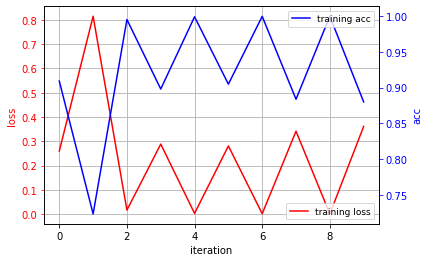

In [17]:
def plot_history(history,loss,acc): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(loss, 'r', label="training loss")
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('loss', color='r')
    ax1.legend(loc="lower right", fontsize=9)    
    ax1.tick_params('y', colors='r')

    ax2 = ax1.twinx()
    ax2.plot(acc, 'b', label="training acc")
    ax2.legend(loc="upper right", fontsize=9)
    ax2.set_ylabel('acc', color='b')        
    ax2.tick_params('y', colors='b')

plot_history(model_ft,loss,acc)


* Frame accuracy score

In [18]:
y_true,y_pred,vid_id = test_model(model_ft, criterion, optimizer_conv)

from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_pred)

0.9047915370255134

In [19]:
import pandas as pd
import glob


df = pd.DataFrame(list(zip(y_true,y_pred,vid_id)),columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

vid_list = list(set(df['vid_id'].values))
y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)

* Kết quả dự đoán video theo cơ chế voting dựa vào kết quả dự đoán các frame

In [20]:
accuracy_score(y_true,y_pred)

0.9487179487179487